<a href="https://colab.research.google.com/github/peterchang0414/randomized_priors/blob/main/randomized_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Randomized Prior Functions for Deep Reinforcement Learning
Based on Osband et al 2018: https://proceedings.neurips.cc/paper/2018/file/5a7b238ba0f6502e5d6be14424b20ded-Paper.pdf

Adapted to JAX from https://www.kaggle.com/code/gdmarmerola/introduction-to-randomized-prior-functions/notebook

Author: Peter G. Chang ([@peterchang0414](https://github.com/peterchang0414))

# 0. Imports

In [5]:
!pip -q install flax

In [27]:
%matplotlib inline

import jax
import jax.numpy as jnp
import flax
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Simple Example

Generate dataset [using](https://arxiv.org/pdf/1505.05424.pdf):
$$
y = x + 0.3 \sin(2 \pi(x + \epsilon)) + 0.3 \sin(4 \pi(x + \epsilon)) + \epsilon
$$
where $\epsilon \sim \mathcal{N}(0, 0.02)$ and $x \sim \mathcal{U}(0.0, 0.5)$.


In [69]:
# Generate dataset and grid
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5)
x_grid = jnp.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(key, x):
  epsilons = jax.random.normal(key, shape=(3,))*0.02
  return (x + 0.3*jnp.sin(2*jnp.pi*(x+epsilons[0])) + 
          0.3*jnp.sin(4*jnp.pi*(x+epsilons[1])) + epsilons[2])

# Define vectorized version of function
target_vmap = jax.vmap(target_toy, in_axes=(0, 0), out_axes=0)

# Generate target values
keys = jax.random.split(subkey, X.shape[0])
Y = target_vmap(keys, X)

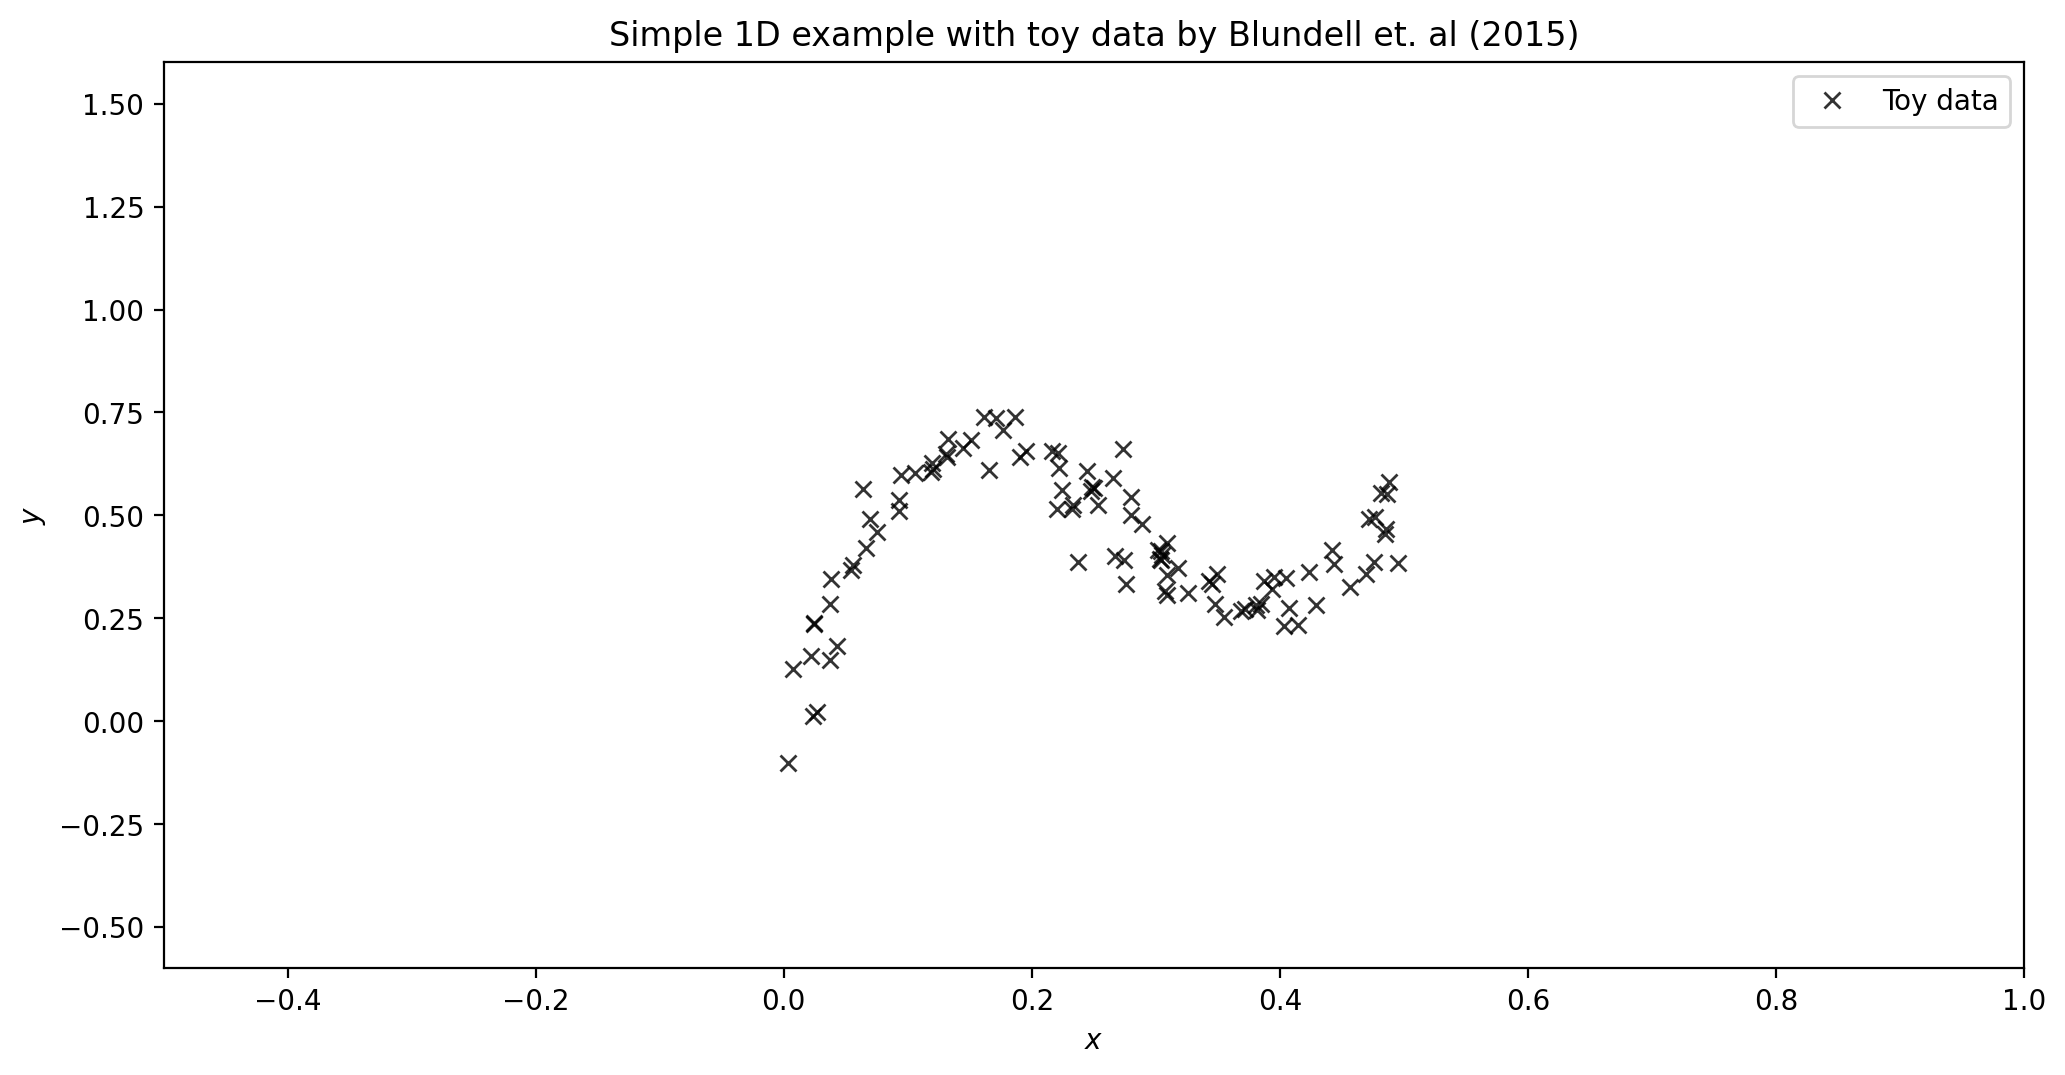

In [70]:
# Plot the generated data
plt.figure(figsize=[12,6], dpi=200)
plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-0.6,1.6)
plt.legend();
plt.show()